# Embedding Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import seaborn as sns

import os
import sys
import yaml

import torch
from torch.utils.data import Dataset, DataLoader

## Prepare sequences

In [2]:
class Synthetic_Dataset(Dataset):
    def __init__(self, eval_length=50, total_timestamps=50000, step=50):
        self.eval_length = eval_length
        self.n_values = total_timestamps
        self.slope = 0.0002  # Slope of the linear trend
        self.intercept = 0  # Intercept of the linear trend
        self.seasonal_amplitude = 0.5  # Amplitude of the seasonal component
        self. seasonal_frequency = 0.05  # Frequency of the seasonal component
        self. noise_variance = 0.1  # Variance of the noise component
        self.step = step
        
        # Time 
        self.time = np.arange(self.n_values)

        # Linear Trend
        self.trend = self.slope * self.time + self.intercept

        # Noise Component
        self.noise = (1+ np.random.normal(0, np.sqrt(self.noise_variance), self.n_values))*0.1

        # Seasonal Component
        self.seasonal = 0.5 + self.seasonal_amplitude * np.sin(2 * np.pi * self.seasonal_frequency * self.time)
        
        self.data = np.column_stack((self.trend, self.noise, self.seasonal))

    def __len__(self):
        return (self.n_values - self.eval_length) // self.step + 1
        
    def __getitem__(self, index):
        index = index * self.step
        data_point = np.float32(self.data[index:index + self.eval_length])
        
        s = {
            'observed_data': data_point,
            'observed_mask': np.ones_like(data_point),
            'gt_mask': np.ones_like(data_point),
            'timepoints': np.arange(self.eval_length) * 1.0, 
        }

        return s

In [3]:
def get_dataloader(batch_size, step=50, eval_length=50, total_timestamps=50000):
    dataset = Synthetic_Dataset(eval_length=eval_length, total_timestamps=50000, step=50) 
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

In [5]:
## Load model

# Get the current working directory
current_folder = os.getcwd()
# Get the parent directory
root_dir = os.path.dirname(current_folder)
sys.path.append(root_dir+'/implementation')
sys.path.append(root_dir)

from implementation.model.main_model import TSDE_base

class TSDE_Synthetic(TSDE_base):
    def __init__(self, config, device, target_dim=3, sample_feat=False):
        super(TSDE_Synthetic, self).__init__(target_dim, config, device, sample_feat)

    def process_data(self, batch, train, sample_feat):
        observed_data = batch["observed_data"].to(self.device).float()
        observed_mask = batch["observed_mask"].to(self.device).float()
        observed_tp = batch["timepoints"].to(self.device).float()
        gt_mask = batch["gt_mask"].to(self.device).float()
        observed_data = observed_data.permute(0, 2, 1)
        observed_mask = observed_mask.permute(0, 2, 1)
        gt_mask = gt_mask.permute(0, 2, 1)

        return (
            observed_data,
            observed_mask,
            None,
            observed_tp,
            gt_mask,
            None,
            None,
            None,
            None,
        )    

In [7]:
## Hyperparams
device = 'cpu'
config_path = root_dir+'/implementation/config/base.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
batch_size = 16
nsample = 100
config["train"]["epochs"]=50

In [10]:
## Train model
from implementation.utils.utils import train

model = TSDE_Synthetic(config, device, target_dim=3, linear=False, sample_feat=False)
loader = get_dataloader(batch_size=batch_size, step=50, eval_length=50, total_timestamps=50000)

train(model, config["train"], loader, nsample=nsample)

100%|██████████| 63/63 [00:07<00:00,  7.95it/s, avg_epoch_loss=0.0709, epoch=49]


In [11]:
def process_loader(loader, model, embeddings, mts):
    with tqdm(loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                (
                    observed_data,
                    observed_mask,
                    feature_id,
                    observed_tp,
                    gt_mask,
                    _,
                    _,
                    _,
                    classes
                ) = model.process_data(batch, sample_feat=model.sample_feat, train=False)
                mts.append(observed_data.cpu())
                mts_emb = model.get_mts_emb(observed_tp, observed_mask, observed_data.unsqueeze(1), feature_id)
                embeddings.append(mts_emb.cpu())

embeddings = []
mts = []
with torch.no_grad():
    model.eval()
    # Process each data loader
    process_loader(loader, model, embeddings, mts)
embeddings_tensor = torch.cat(embeddings, dim=0).numpy()
mts_tensor =  torch.cat(mts, dim=0).numpy()

100%|██████████| 63/63 [00:01<00:00, 44.35it/s]


In [36]:
example_emb = embeddings_tensor[0, :16,:,:]
example_mts = mts_tensor[0]

time_embedding = np.mean(example_emb[:16], axis = 1)
feature_embedding = np.mean(example_emb[16:], axis = 2)

# Clustering

In [12]:
from sklearn.cluster import KMeans

## Trend Embedding Visualization
trend_embeddings = example_emb[:,0,:]
n_clusters = 1
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(trend_embeddings)
kmeans_centroids = kmeans.cluster_centers_

mean = np.mean(kmeans_centroids, axis= 1, keepdims=True)
std = np.std(kmeans_centroids, axis= 1, keepdims=True)
normalized_trend = (kmeans_centroids-mean)/std


## Noise Embedding Visualization
noise_embeddings = example_emb[:,1,:]
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(noise_embeddings)
kmeans_centroids = kmeans.cluster_centers_

mean = np.mean(kmeans_centroids, axis= 1, keepdims=True)
std = np.std(kmeans_centroids, axis= 1, keepdims=True)
normalized_noise = (kmeans_centroids-mean)/std

## Seasonal Embedding Visualization
seasonal_embeddings = example_emb[:,2,:]
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(seasonal_embeddings)
kmeans_centroids = kmeans.cluster_centers_

mean = np.mean(kmeans_centroids, axis= 1, keepdims=True)
std = np.std(kmeans_centroids, axis= 1, keepdims=True)
normalized_seasonal = (kmeans_centroids-mean)/std


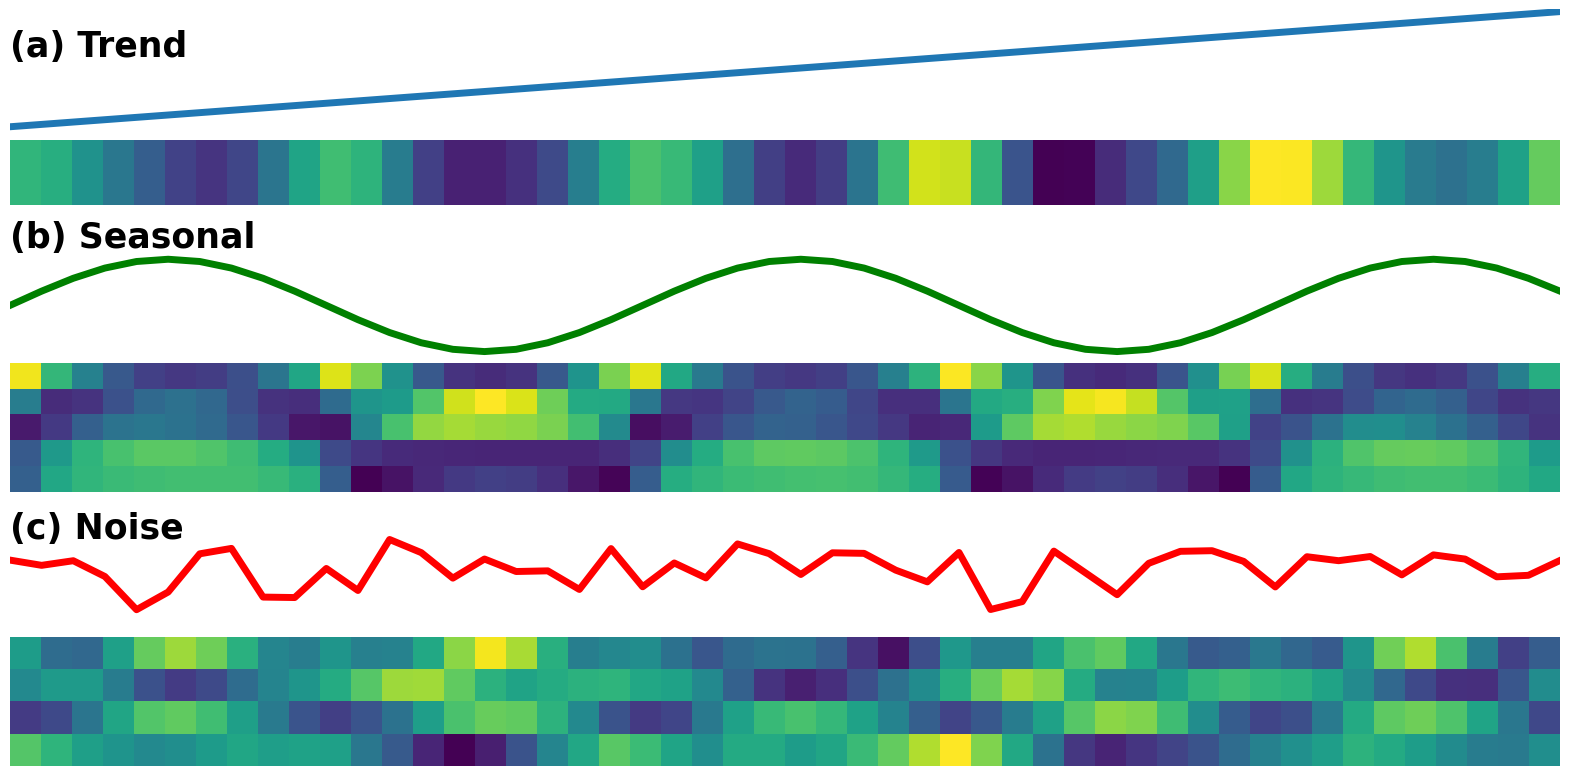

In [213]:
L=50
timestamps = np.arange(L)
fig = plt.figure(figsize=(20, 10))
spec = gridspec.GridSpec(nrows=12, ncols=1, height_ratios=[1, 0.01, 0.5, 0.2, 1, 0.01, 1, 0.1, 1, 0.01, 1, 0.1])
# Create the figure at center
ax_col1_raw1 = fig.add_subplot(spec[0, 0])
ax_col1_raw2 = fig.add_subplot(spec[2, 0])

ax_col1_raw3 = fig.add_subplot(spec[4, 0])
ax_col1_raw4 = fig.add_subplot(spec[6, 0])
ax_col1_raw5 = fig.add_subplot(spec[8, 0])
ax_col1_raw6 = fig.add_subplot(spec[10, 0])

## Plot signals
ax_col1_raw1.set_xticks([])
ax_col1_raw1.set_yticks([])

ax_col1_raw2.set_xticks([])
ax_col1_raw2.set_yticks([])

ax_col1_raw3.set_xticks([])
ax_col1_raw3.set_yticks([])

ax_col1_raw4.set_xticks([])
ax_col1_raw4.set_yticks([])

ax_col1_raw5.set_xticks([])
ax_col1_raw5.set_yticks([])

ax_col1_raw6.set_xticks([])
ax_col1_raw6.set_yticks([])



ax_col1_raw1.set_xlim(0, 49)
ax_col1_raw3.set_xlim(0, 49)
ax_col1_raw5.set_xlim(0, 49)
ax_col1_raw1.set_ylim(9.099,9.11)
ax_col1_raw3.set_ylim(-0.1, 1.3)
ax_col1_raw5.set_ylim(0, 0.2)
ax_col1_raw1.annotate('(a) Trend', xy=(0, 9.106), fontsize=25, color='black', weight='bold')
ax_col1_raw3.annotate('(b) Seasonal', xy=(0, 1.13), fontsize=25, color='black', weight='bold')
ax_col1_raw5.annotate('(c) Noise', xy=(0, 0.15), fontsize=25, color='black', weight='bold')
#example_emb = np.log(np.abs(example_emb) + 1)
mean = np.mean(example_emb, axis= 2, keepdims=True)
std = np.std(example_emb, axis= 2, keepdims=True)

normalized_emb = (example_emb-mean)/std


# List of all axes
axes = [ax_col1_raw1, ax_col1_raw2, ax_col1_raw3, ax_col1_raw4, ax_col1_raw5, ax_col1_raw6]

# Hide the spines for each subplot
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

## Temporal embeddings
plot = sns.lineplot(example_mts[0], ax=ax_col1_raw1, linewidth=5)
plot = sns.lineplot(example_mts[2], ax=ax_col1_raw3, linewidth=5, color='g')
plot = sns.lineplot(example_mts[1], ax=ax_col1_raw5, linewidth=5, color='r')
plot = sns.heatmap(normalized_trend, ax=ax_col1_raw2, cmap=sns.color_palette("viridis", as_cmap=True),cbar=False, yticklabels=False, xticklabels=False)
plot = sns.heatmap(normalized_noise, ax=ax_col1_raw6, cmap=sns.color_palette("viridis", as_cmap=True),cbar=False, yticklabels=False, xticklabels=False)
plot = sns.heatmap(normalized_seasonal, ax=ax_col1_raw4, cmap=sns.color_palette("viridis", as_cmap=True),cbar=False, yticklabels=False, xticklabels=False)
plt.subplots_adjust(hspace=0.005, wspace=0.01)



# Save the plot to a PDF file
plt.savefig("embed_viz.pdf", format='pdf')